# Monitoring water hyacinth invasion at Hartbeespoort Dam

## Background

Hartbeespoort Dam is located in South Africa's North West Province. The dam has been plagued by uncontrolled water hyacinth growth since the 1970s. At times, water hyacinth covers 60% of the dam surface area. Several remediation projects have tried to address the problem. The water hyacinth causes toxic algal blooms that affect bird and animal life, and present a risk to human health. 

The Mail and Guardian newspaper published an article about the use of a "planthopper" insect to control the spread of the weed:
https://mg.co.za/the-green-guardian/2023-11-12-tiny-planthoppers-reduce-invasive-water-hyacinth-on-hartbeespoort-dam-to-5/

Monitoring recent and historic hyacinth growth can raise awareness of the risks and contribute to remediation planning. Data from the Sentinel-2 satellites can be used to visualise and measure the hyacinth coverage in the dam.

Sentinel-2 data is available on the AWS Open Data Registry at https://registry.opendata.aws/sentinel-2/ and as Cloud Optimised GeoTiffs (COGs) at https://registry.opendata.aws/sentinel-2-l2a-cogs/. We will use the latter for this project.


## GeoData workflow

1. Identify the area of interest that we will be working with, and list the relevant time periods
2. Identify the data source and the format of the data we will be working with
3. Set a baseline for the monitoring - this is a model of the dam when water hyacinth growth in very low
4. Identify other dates of interest
5. Download the applicable data for all dates from our AWS Open Data data source
6. Mask out the areas outside of the dam perimeter
7. Calculate the percentage of hyacinth coverage

## References

The code in this notebook is based on the excellent work of others from across the Internet:
* https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html
* https://www.matecdev.com/posts/landsat-sentinel-aws-s3-python.html
* https://gist.github.com/bradyrx/1a15d8c45eac126e78d84af3f123ffdb

## Environment setup

The environment can be set up on SageMaker Studio Lab using a Geodata kernel. The Geodata kernel will preinstall many of the Python packages we need. You can install any extra dependencies using pip.

In [1]:
#%pip install dask
#%pip install dask[distributed]
#%pip install odc-ui
#%pip install pystac_client
#%pip install odc-stac
#%pip install xhistogram
#%pip install descartes

In [4]:
import dask.distributed
import folium
import folium.plugins
import numpy as np
import geopandas as gpd
import odc.ui
import shapely.geometry
import yaml
import rasterio
import rasterio.features
import matplotlib.pyplot as plt
import xarray as xr
import requests
import os
import zipfile

from affine import Affine
from branca.element import Figure
from IPython.display import HTML, display
from odc.algo import to_rgba
from pystac_client import Client
from xhistogram.xarray import histogram
from odc.stac import configure_rio, stac_load
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon

%matplotlib inline

## Load Shapefile for Dams in South Africa

You can find a geo dataset for dams in South Africa here:
https://za.africageoportal.com/search?collection=Dataset

We will download the Shapefile for the dams programmatically - the URL referenced may change over time. Please update as needed.


In [9]:
url = "https://opendata.arcgis.com/api/v3/datasets/0d0d339efe1c420c9c6d19aa20eebb2e_0/downloads/data?format=shp&spatialRefId=4326&where=1%3D1"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a file
    zip_filename = "data.zip"
    with open(zip_filename, "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")

    # Create the target directory
    output_dir = "SA_Dams"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Unzip the file
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"File unzipped successfully into '{output_dir}' directory.")

    # Delete the zip file after extraction
    os.remove(zip_filename)

else:
    print("Failed to download the file. Status code:", response.status_code)

File downloaded successfully.
File unzipped successfully into 'SA_Dams' directory.


In [10]:
shpfile = gpd.read_file('SA_Dams/DWS_Dams_50k.shp')

#Print out a preview of the file if you want to see the column names
#shpfile

In [11]:
def select_shape(shpfile, category, name):
    """Select the submask of interest from the shapefile.
    Args:
        shpfile: (*.shp)
        category: (str) header of shape file from which to filter shape.
            (Run print(shpfile) to see options)
        name: (str) name of shape relative to category.
    Returns:
        shapely polygon
    """
    s = shpfile
    polygon = s[s[category] == name]
    polygon = polygon.geometry[:].unary_union
    return polygon

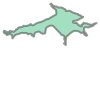

In [12]:
hartbeespoort = select_shape(shpfile, 'Dam_Name', 'Hartbeespoort')
hartbeespoort

In [13]:
#convert the shape to a GeoDataFrame to use later
geo_series = gpd.GeoSeries([hartbeespoort])
harties_gdf = gpd.GeoDataFrame(geometry=geo_series)
harties_gdf.crs = "EPSG:3857"

### Dask

https://docs.dask.org/en/stable/

Dask is a library used for parallel processing - this is useful when loading large geospatial datasets. In this notebook we aren't processing huge data volumes, but the example can be expanded later to load months or years worth of data. Dask will be useful then!

In [14]:
client = dask.distributed.Client()
display(client)

<Client: 'tcp://127.0.0.1:38553' processes=4 threads=4, memory=15.47 GiB>

## Finding the right data

Sentinel-2 satellites move through space taking photographs of the earth that are consolidated into data products - https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products. The data products are divided into tiles or "granules". Given a specific area or point on earth, we need to find the corresponding granules containing the captured data. The Sentinel-2 data is hosted on AWS, but to look up the data in your area of interest, you need to consult a data catalog. Geospatial data is typically indexed into a catalog using a common format called the SpatioTemporal Assets Catalog (*STAC* - https://stacspec.org/en). We'll use a catalogue for the AWS-hosted data, maintained by Element 84 at https://earth-search.aws.element84.com/v1/.

In [15]:
km2deg = 1.0 / 111 #approximation
longitude, latitude = (27.848, -25.748)
r = 10 * km2deg #make the bounding box ~20km high & ~20km wide
bbox = (longitude - r, latitude - r, longitude + r, latitude + r)

#Use a catalog that references the data locations on AWS
catalog = Client.open("https://earth-search.aws.element84.com/v1/")

query = catalog.search(
    collections=["sentinel-2-l2a"], 
    datetime="2023-09-26",
    bbox = bbox,
    max_items=10
)

clear_day_sentinel_products = list(query.items())
print(f"Found: {len(clear_day_sentinel_products):d} datasets for the clear day dataset")

query = catalog.search(
    collections=["sentinel-2-l2a"], 
    datetime="2023-01-24",
    bbox = bbox,
    max_items=10
)

high_coverage_day_sentinel_products = list(query.items())
print(f"Found: {len(high_coverage_day_sentinel_products):d} datasets for the high coverage day dataset")

query = catalog.search(
    collections=["sentinel-2-l2a"], 
    datetime="2023-06-18",
    bbox = bbox,
    max_items=10
)

sinking_coverage_day_sentinel_products = list(query.items())
print(f"Found: {len(high_coverage_day_sentinel_products):d} datasets for the sinking coverage day dataset")


Found: 1 datasets for the clear day dataset
Found: 1 datasets for the high coverage day dataset
Found: 1 datasets for the sinking coverage day dataset


Fetch a GeoDataFrame from the catalogued data using the EPSG Geodetic Parameter Dataset format (https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) so that we can display the output.

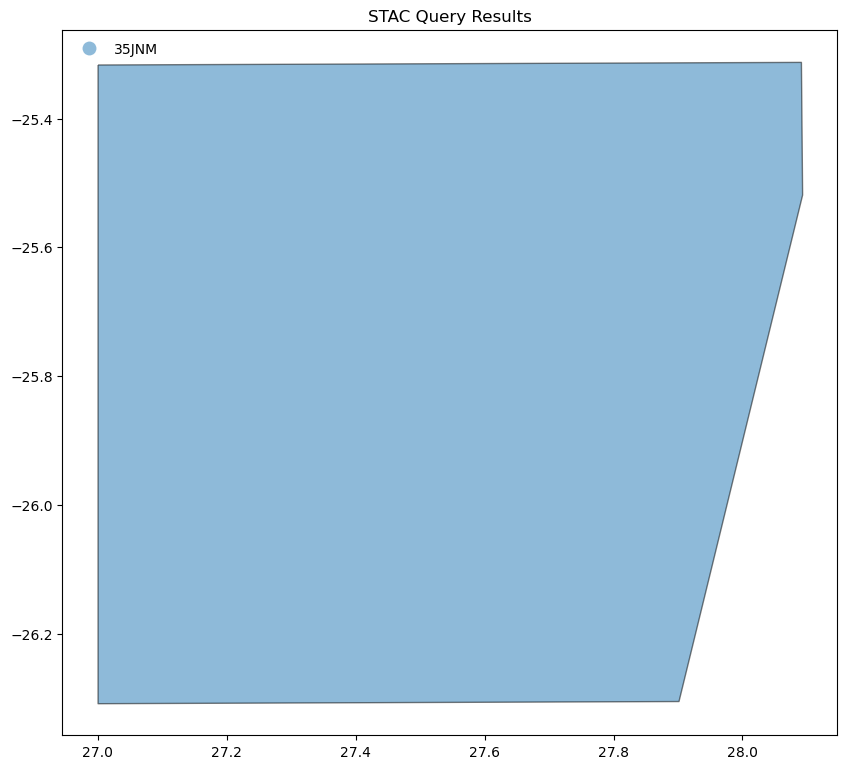

In [16]:
# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id in the format UTM Zone + Latitude Band + Grid Square
# UTM Zones: https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system
# Latitude Bands: https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#Latitude_bands_2
# Grid Square: see https://en.wikipedia.org/wiki/Military_Grid_Reference_System
# e.g. 35J + N + M = 35JNM
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(10, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

We can visually plot the granule on top of our area of interest to check the coverage. Some granules may bisect the given area. In our case, we have full coverage with a single granule.

In [17]:
def convert_to_leaflet(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [18]:
fig = Figure(width="600px", height="500px")
map = folium.Map(scrollWheelZoom=False)
fig.add_child(map)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map,
)

map.fit_bounds(bounds=convert_to_leaflet(gdf.unary_union.bounds))
display(fig)

# Load RGB and Scene Classification bands

We can zoom in on the dam further. We use the ODC library to load data from AWS, specifying the spectral bands we are interested in - see https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands. "SCL" is a special map that calculates the scene classification of each pixel in a dataset - https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview. We are interested in seeing which pixels represent water, and which represent vegetation. 

| Value   | Colour    | Classification       |
| ---    | ---   | ---     |
| 0 | black | no data |
| 1 | red | saturated or defective |
| 2 | dimgrey | cast shadows |
| 3 | brown | cloud shadows |
| 4 | green | vegetation |
| 5 | yellow | non vegetated |
| 6 | blue | water |
| 7 | gray | unclassified |
| 8 | lightgray | cloud (medium probability) |
| 9 | white | cloud (high probability) |
| 10 | lightskyblue | thin cirrus |
| 11 | magenta | snow |

In [19]:
stac_config = """---
sentinel-s2-l2a-cogs:
  assets:
    '*':
      data_type: uint16
      nodata: 0
      unit: '1'
    SCL:
      data_type: uint8
      nodata: 0
      unit: '1'
    visual:
      data_type: uint8
      nodata: 0
      unit: '1'
  aliases:  # Alias -> Canonical Name
    red: B04
    green: B03
    blue: B02
"*":
  warnings: ignore # Disable warnings about duplicate common names
"""
stac_config = yaml.load(stac_config, Loader=yaml.SafeLoader)

In [20]:
def load_sentinel_data_from_AWS(sentinel_products, crs, stac_config, bbox):
    """
    Method to load the R, G, B, NIR and Scene Classification bands
    for a given sentinel product
    """
    return stac_load(
    sentinel_products,
    bands=("red", "green", "blue", "scl", "nir"),
    crs=crs,
    resolution=0.00005, # measured in degrees - matches the crs used
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=stac_config,
    bbox=bbox)

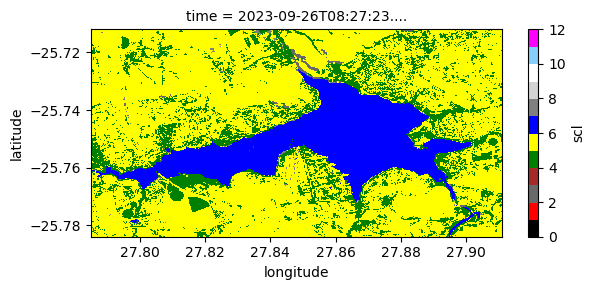

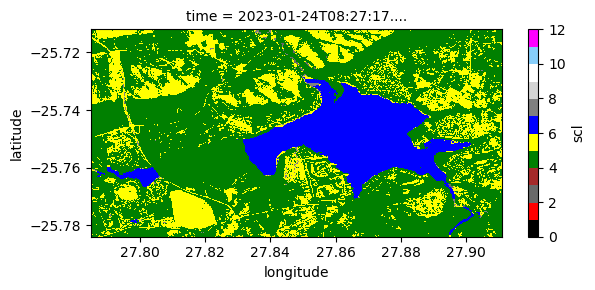

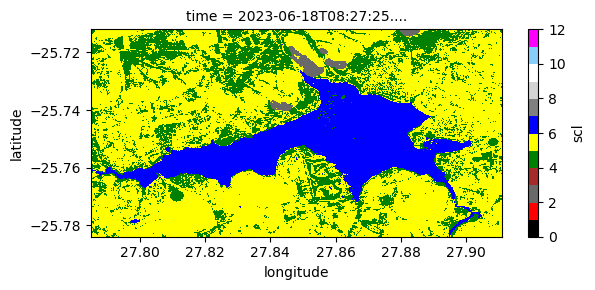

In [21]:
#Coordinate reference system is World Geodetic System 84
crs = "wgs84"
r1 = 7 * km2deg
r2 = 4 * km2deg
small_bbox = (longitude - r1, latitude - r2, longitude + r1, latitude + r2)

#This dataset is freely available, so we don't need to provide AWS credentials
#The client parameter here is the dask client created above
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

#Load Sentinel bands for the different days
yy_clear = load_sentinel_data_from_AWS(clear_day_sentinel_products, crs, stac_config, small_bbox)
yy_covered = load_sentinel_data_from_AWS(high_coverage_day_sentinel_products, crs, stac_config, small_bbox)
yy_sinking = load_sentinel_data_from_AWS(sinking_coverage_day_sentinel_products, crs, stac_config, small_bbox)

#Make a colour map for our plot using the colours in the table above
cmap = plt.cm.colors.ListedColormap(['black', 'red', 'dimgray', 'brown', 'green', 'yellow', 'blue', 'gray', 'lightgray', 'white', 'lightskyblue', 'magenta'])
bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

yy_clear.scl.plot.imshow(col="time", size=3, aspect=1.75, vmin=0, vmax=12, cmap=cmap, norm=norm)
yy_covered.scl.plot.imshow(col="time", size=3, aspect=1.75, vmin=0, vmax=12, cmap=cmap, norm=norm)
yy_sinking.scl.plot.imshow(col="time", size=3, aspect=1.75, vmin=0, vmax=12, cmap=cmap, norm=norm)

We are actually only interested in the water hyacinth growing within the dam's border. To focus on that we will create a mask using the <code>harties</code> GeoDataFrame we created at the beginning.

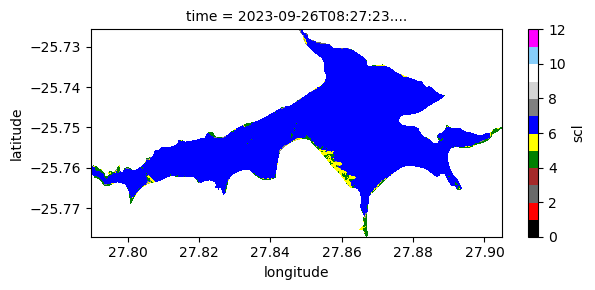

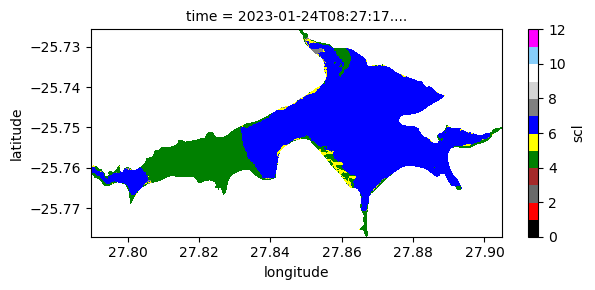

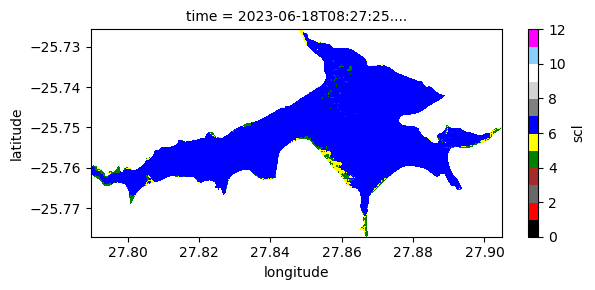

In [22]:
transform = Affine.from_gdal(*yy_clear.geobox.transform.to_gdal())
mask_array = rasterio.features.geometry_mask([geom for geom in harties_gdf.geometry],
                                        transform=transform,
                                        invert=True,
                                        out_shape=(yy_clear.dims['latitude'], yy_clear.dims['longitude']),
                                        all_touched=True)

mask = xr.DataArray(mask_array, dims=('latitude', 'longitude'))

masked_yy_clear = yy_clear.where(mask, drop=True)
masked_yy_covered = yy_covered.where(mask, drop=True)
masked_yy_sinking = yy_sinking.where(mask, drop=True)

masked_yy_clear.scl.plot.imshow(col="time", size=3, aspect=1.75, vmin=0, vmax=12, cmap=cmap, norm=norm)
masked_yy_covered.scl.plot.imshow(col="time", size=3, aspect=1.75, vmin=0, vmax=12, cmap=cmap, norm=norm)
masked_yy_sinking.scl.plot.imshow(col="time", size=3, aspect=1.75, vmin=0, vmax=12, cmap=cmap, norm=norm)

# Calculating NDVI

Scene classification does not provide the data resolution that we would like for our calculation. We are looking for areas of dense vegetation growth, but also for situations where vegetation may be sinking in the water. For that we can calculate a Normalised Difference Vegitation Index (NDVI) layer that will give us indication of green leaves inside the dam perimeter.

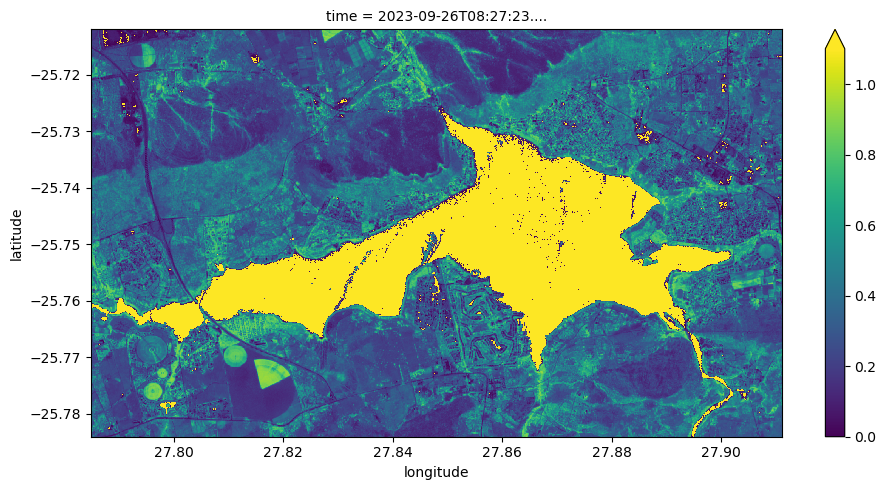

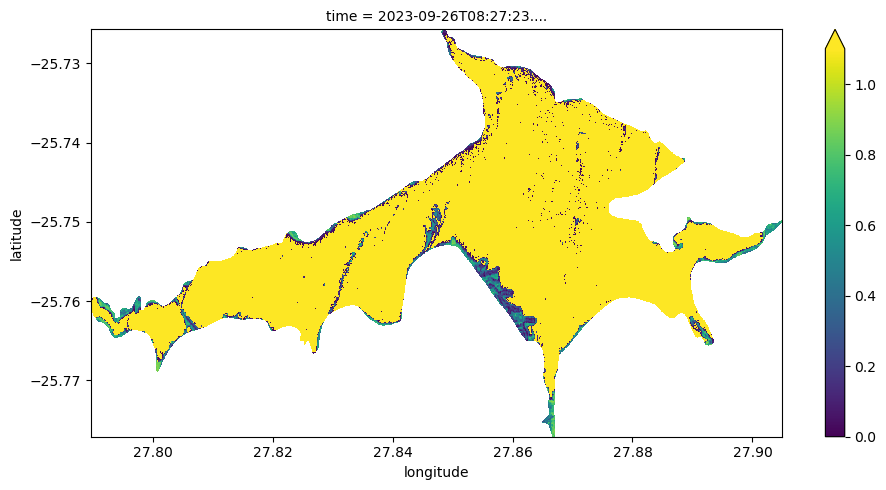

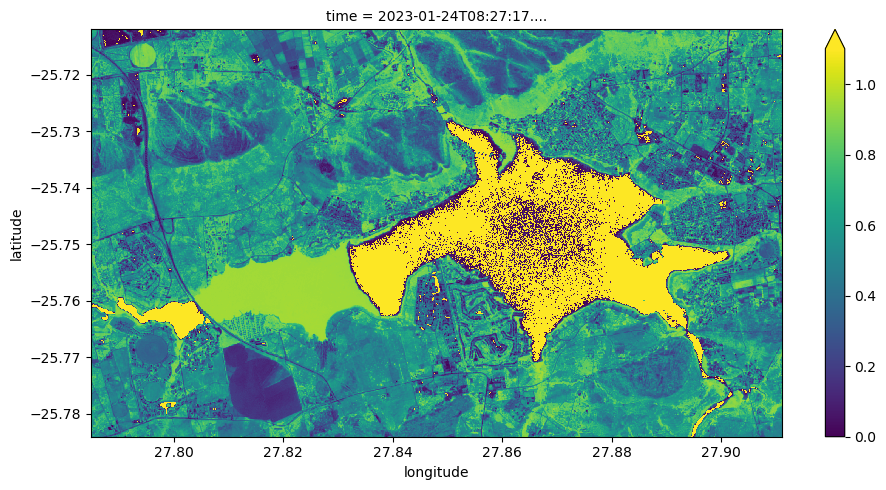

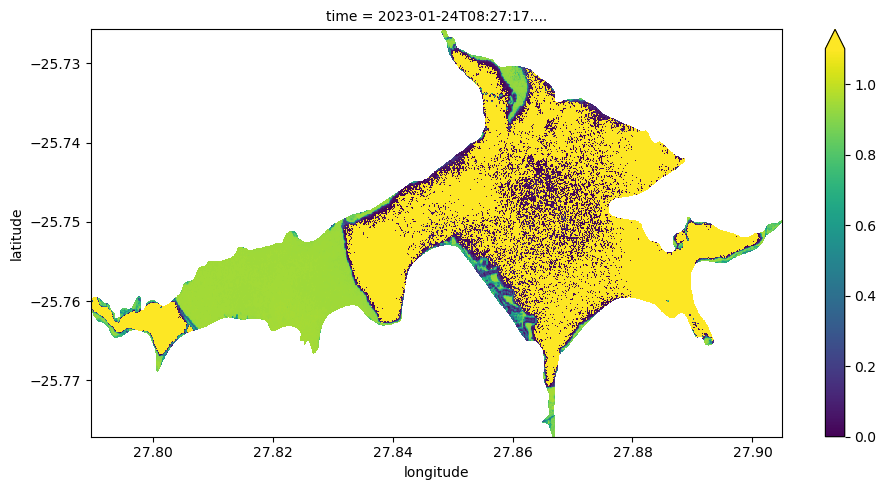

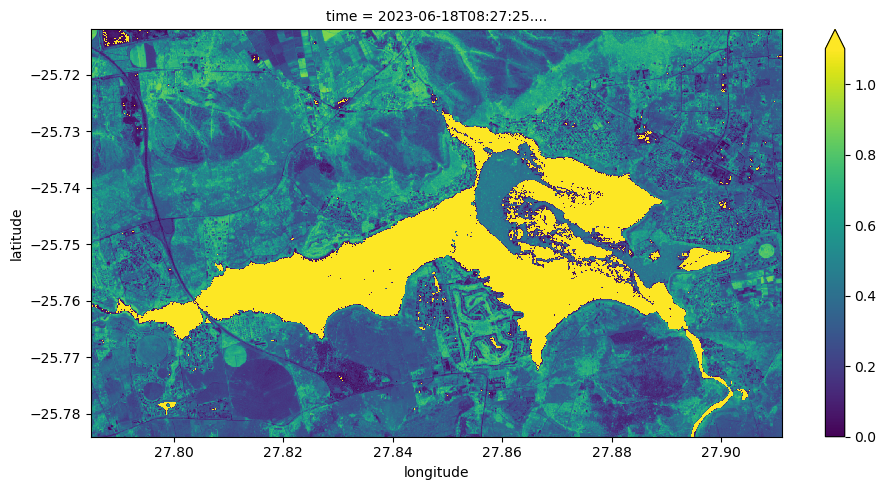

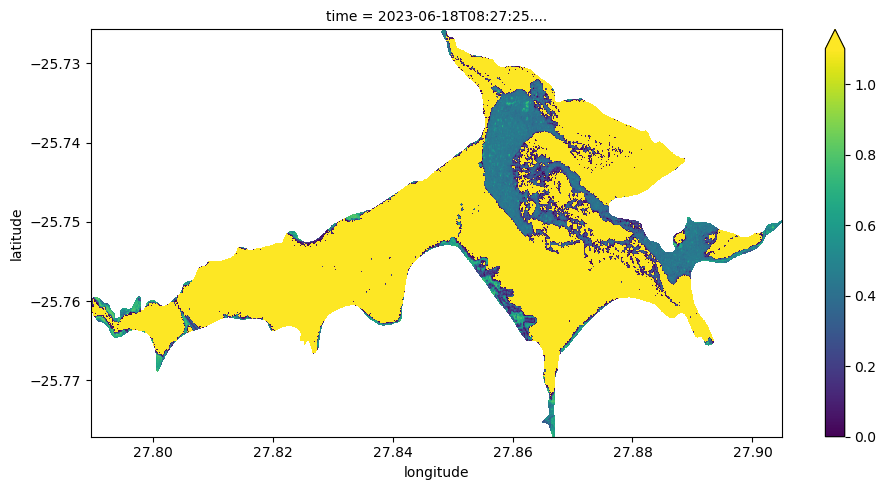

In [23]:
ndvi_clear = (yy_clear.nir-yy_clear.red)/(yy_clear.nir+yy_clear.red)
ndvi_clear.plot.imshow(col="time", size=5, aspect=1.75, vmax=1.1)
masked_ndvi_clear = ndvi_clear.where(mask, drop=True)
masked_ndvi_clear.plot.imshow(col="time", size=5, aspect=1.75, vmax=1.1)

ndvi_covered = (yy_covered.nir-yy_covered.red)/(yy_covered.nir+yy_covered.red)
ndvi_covered.plot.imshow(col="time", size=5, aspect=1.75, vmax=1.1)
masked_ndvi_covered = ndvi_covered.where(mask, drop=True)
masked_ndvi_covered.plot.imshow(col="time", size=5, aspect=1.75, vmax=1.1)

ndvi_sinking = (yy_sinking.nir-yy_sinking.red)/(yy_sinking.nir+yy_sinking.red)
ndvi_sinking.plot.imshow(col="time", size=5, aspect=1.75, vmax=1.1)
masked_ndvi_sinking = ndvi_sinking.where(mask, drop=True)
masked_ndvi_sinking.plot.imshow(col="time", size=5, aspect=1.75, vmax=1.1)

Now we have the masked areas and values representing the density of vegetation present in the water.

# Calculating dam coverage percentage

In [24]:
vegetation_range_min = 0.0
vegetation_range_max = 0.99

# Create a boolean mask for values within the range
vegetation_mask_clear = (masked_ndvi_clear >= vegetation_range_min) & (masked_ndvi_clear <= vegetation_range_max)
vegetation_mask_covered = (masked_ndvi_covered >= vegetation_range_min) & (masked_ndvi_covered <= vegetation_range_max)
vegetation_mask_sinking = (masked_ndvi_sinking >= vegetation_range_min) & (masked_ndvi_sinking <= vegetation_range_max)

count_clear_day = masked_ndvi_clear.where(vegetation_mask_clear).count().compute().item()
#Total will be the same for all the different scenes
total_count = masked_ndvi_clear.count().compute().item()
percent_clear_day = round((count_clear_day / total_count) * 100, 2)

count_covered_day = masked_ndvi_covered.where(vegetation_mask_covered).count().compute().item()
percent_covered_day = round((count_covered_day / total_count) * 100, 2)

count_sinking_day = masked_ndvi_sinking.where(vegetation_mask_sinking).count().compute().item()
percent_sinking_day = round((count_sinking_day / total_count) * 100, 2)

print(f"Percentage coverage calculations")
print(f"--------------------------------")
print(f"Clear day (2023-09-26): {count_clear_day} / {total_count} = {percent_clear_day}%")
print(f"Covered day (2023-01-24): {count_covered_day} / {total_count} = {percent_covered_day}%")
print(f"Sinking day (2023-06-18): {count_sinking_day} / {total_count} = {percent_sinking_day}%")

Percentage coverage calculations
--------------------------------
Clear day (2023-09-26): 60987 / 627185 = 9.72%
Covered day (2023-01-24): 255817 / 627185 = 40.79%
Sinking day (2023-06-18): 156123 / 627185 = 24.89%


# Sense checking with RGBA images

To sense check the coverage percentage calculation we have done, we can look at higher resolution RGBA images of the dam

In [25]:
im_small_clear = to_rgba(yy_clear, clamp=(1, 3000)).compute()
img_clear_zoomed_in = odc.ui.mk_data_uri(
    odc.ui.to_jpeg_data(im_small_clear.isel(time=0).data, quality=80), "image/jpeg"
)

im_small_covered = to_rgba(yy_covered, clamp=(1, 3000)).compute()
img_covered_zoomed_in = odc.ui.mk_data_uri(
    odc.ui.to_jpeg_data(im_small_covered.isel(time=0).data, quality=80), "image/jpeg"
)

im_small_sinking = to_rgba(yy_sinking, clamp=(1, 3000)).compute()
img_sinking_zoomed_in = odc.ui.mk_data_uri(
    odc.ui.to_jpeg_data(im_small_sinking.isel(time=0).data, quality=80), "image/jpeg"
)

HTML(
    data=f"""
     <div display="table">
          <div width=30%><img src="{img_clear_zoomed_in}" alt="Sentinel-2 Zoom in - clear day"></div>
          <div width=30%><img src="{img_covered_zoomed_in}" alt="Sentinel-2 Zoom in - covered day"></div>
          <div width=30%><img src="{img_sinking_zoomed_in}" alt="Sentinel-2 Zoom in - sinking day"></div>
    </div>
"""
)
